In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df_complete= pd.read_csv('dataset.csv',index_col=0)

In [5]:
# Copiar el DataFrame original
df_new = df_complete.copy()

# Crear la nueva columna 'class_name' basada en la columna 'class'
df_new['class_name'] = df_complete['class']



In [6]:
# Crear un diccionario de mapeo
mapping = {'Human-Generated-Text': 0, 'AI-Generated-Text': 1}

In [7]:
#Reemplazar las clases en la columna 'class' con el mapeo

df_complete['class'] = df_complete['class'].map(mapping)

In [ ]:
df_complete

## Forma 1 de limpieza

In [10]:
import gensim # take text for clean and tokenize list of words
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords') #language package for english
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = list(stopwords.words("english"))

In [19]:
# Inicializamos PorterStemmer
ps = PorterStemmer()

# Cargamos las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Lista para almacenar el texto limpio
text_cleaned = []

# Proceso de limpieza, preprocesamiento y stemming
for text in df_complete['text']:
    words = []
    for word in gensim.utils.simple_preprocess(text):  # Convertir a palabras en minúsculas
        # Filtrar stopwords y palabras irrelevantes
        if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words:
            # Aplicar PorterStemmer para obtener la raíz de la palabra
            stemmed_word = ps.stem(word)
            words.append(stemmed_word)
    
    # Agregar el texto limpio y procesado a la lista
    text_cleaned.append(' '.join(words))

# Guardar el texto limpio y con stemming en el DataFrame
df_complete['text_cleaned'] = text_cleaned


In [20]:
df_complete.head(4)

,text,class,text_cleaned
0,Sekhukhune I (Matsebe; circa 1814 – 13 Septemb...,1,sekhukhun matseb circa septemb known sekhukhun...
1,Mount Washington is a peak in the White Mount...,1,mount washington peak white mountain new hamps...
2,Acer hillsi is an extinct maple species that w...,1,acer hillsi extinct mapl speci endem central a...
3,Derrick George Sherwin (16 April 1936 – 17 Oct...,0,derrick georg sherwin april octob english tele...


In [25]:
X = df_complete["text_cleaned"]
y = df_complete["class"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Es muy recomendable escalar las características (variables X) cuando utilizas un modelo de SVM, ya que este modelo es sensible a las escalas de las características.

¿Por qué?
Los modelos de SVM calculan distancias entre puntos y fronteras de decisión. Si una característica tiene un rango mucho mayor que otra (por ejemplo, una que va de 0 a 1000 y otra que va de 0 a 1), las características de mayor escala dominarán las distancias y afectarán la precisión del modelo.

In [32]:
# Text Tokenization

from sklearn.feature_extraction.text import CountVectorizer

In [33]:
# Tokenization is necesary for preprocessing text to ML
# We will use CountVectorizer

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train) # dtm as document-term matrix
X_test_dtm = vect.transform(X_test)

In [35]:
# Escalar las características de X_train y X_test

from sklearn.preprocessing import StandardScaler # for standardization us
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dtm)
X_test_scaled = scaler.transform(X_test_dtm)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

### Machine learning models

In [31]:
# Aplicamos primero el modelo Multinomial de Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [32]:
spam_detect_model = MultinomialNB().fit(X_train_dtm, y_train)

In [33]:
# hacemos la predicción 
y_pred=spam_detect_model.predict(X_test_dtm)

In [34]:
# obtenemos la precisión de nuestro modelo, accuracy
accuracy1=spam_detect_model.score(X_test_dtm, y_test)
accuracy1

0.72192

In [35]:
# obtenemos la descomposición de la precisión, en sus tres variantes (precision, recall, f1score)

from sklearn.metrics import classification_report
# Metrics for NB

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73     37535
           1       0.74      0.68      0.71     37465

    accuracy                           0.72     75000
   macro avg       0.72      0.72      0.72     75000
weighted avg       0.72      0.72      0.72     75000



In [36]:
# obtenemos la matriz de decisión del primer modelo
from sklearn.metrics import confusion_matrix
matriz1=confusion_matrix(y_test, y_pred)


In [37]:
from tabulate import tabulate

In [38]:

encabezado=['Naive Bayes','AI','Human']
indice=['AI','Human']
print(tabulate(matriz1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═══════════════╤═══════╤═════════╕
│ Naive Bayes   │    AI │   Human │
╞═══════════════╪═══════╪═════════╡
│ AI            │ 28690 │    8845 │
├───────────────┼───────┼─────────┤
│ Human         │ 12011 │   25454 │
╘═══════════════╧═══════╧═════════╛


In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

<Figure size 800x600 with 0 Axes>

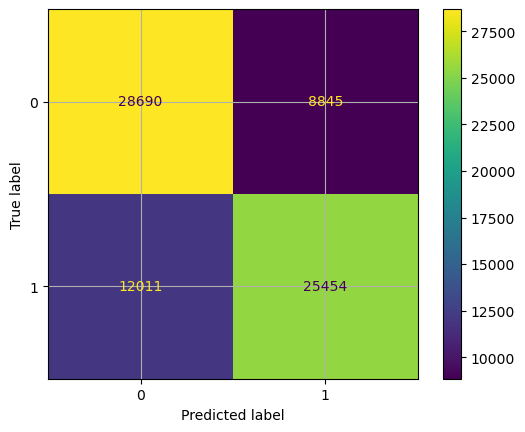

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=matriz1)
plt.figure(figsize=(8, 6))
disp.plot(cmap='viridis')  
plt.grid(True)
plt.show()

In [41]:
# Ahora hacemos la agrupación con el segundo modelo, el Support Vector Machine
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

In [42]:
SS = svm.LinearSVC()

In [43]:
# Para hacer la posterior representación de la curva de ROC, necesitamos obtener las probabilidades, y para ello usamos
# la función CalibratedClassifier
clf_svm = CalibratedClassifierCV(estimator=SS) 

In [44]:
# Ajustamos el modelo y realizamos la predicción
modelo2=clf_svm.fit(X_train_dtm, y_train)
pred_mod2=modelo2.predict(X_test_dtm)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
# Descomposición de la precisión del segundo modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_mod2))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     37535
           1       0.91      0.92      0.91     37465

    accuracy                           0.91     75000
   macro avg       0.91      0.91      0.91     75000
weighted avg       0.91      0.91      0.91     75000



In [46]:
# Matriz de decisión modelo SVM
matriz2=confusion_matrix(y_test, pred_mod2)
encabezado=['SVM','Spam','No spam']
indice=['Spam','No spam']
print(tabulate(matriz2, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))
accuracy2=modelo2.score(X_test_dtm, y_test)

╒═════════╤════════╤═══════════╕
│ SVM     │   Spam │   No spam │
╞═════════╪════════╪═══════════╡
│ Spam    │  34102 │      3433 │
├─────────┼────────┼───────────┤
│ No spam │   3142 │     34323 │
╘═════════╧════════╧═══════════╛


In [47]:

# Para hacer la comparativa con la curva de ROC, primero tenemos que obtener las probabilidades y después obtenemos los scores
from sklearn.metrics import roc_curve, roc_auc_score

y_score1 = spam_detect_model.fit(X_train_dtm, y_train).predict_proba(X_test_dtm)[:,1]
y_score2 = clf_svm.fit(X_train_dtm, y_train).predict_proba(X_test_dtm)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

roc1=roc_auc_score(y_test, y_score1)
roc2=roc_auc_score(y_test, y_score2)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


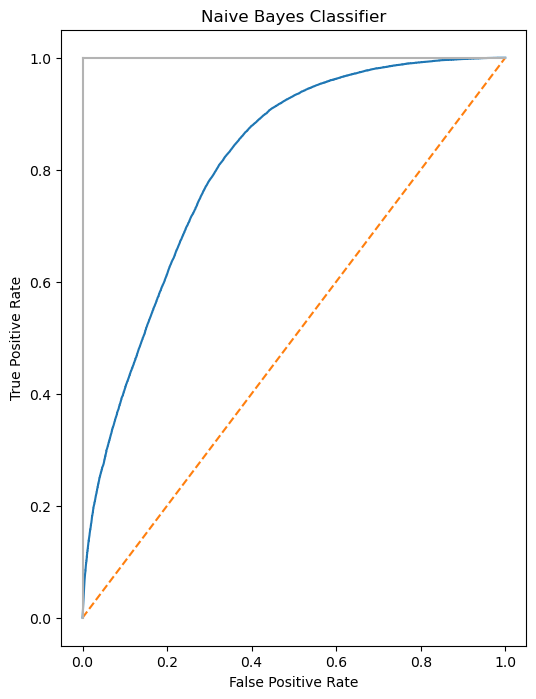

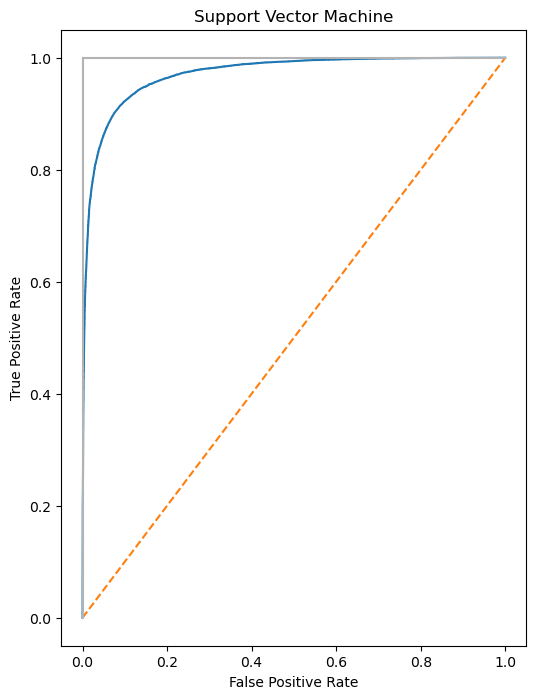

In [48]:
# Graficamos los valores de la curva ROC
plt.subplots(1, figsize=(6,8))
plt.title('Naive Bayes Classifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(6,8))
plt.title('Support Vector Machine')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:

# Tabla resumen y comparativa entre la precisión y la curva ROC de los dos modelos
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_mod1=precision_score(y_test, y_pred, average='weighted')
precision_mod2=precision_score(y_test, pred_mod2, average='weighted')

recall_mod1=recall_score(y_test, y_pred, average='weighted')
recall_mod2=recall_score(y_test, pred_mod2, average='weighted')
f1_mod1=f1_score(y_test, y_pred, average='weighted')
f1_mod2=f1_score(y_test, pred_mod2, average='weighted')

summary1=[[precision_mod1,recall_mod1,f1_mod1,roc1],[precision_mod2,recall_mod2,f1_mod2,roc2]]
encabezado=['Ratios','Precision','Recall','F1 Score','ROC/AUC']
indice=['Naive Bayes','SVM']
print(tabulate(summary1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Ratios      │   Precision │   Recall │   F1 Score │   ROC/AUC │
╞═════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Naive Bayes │    0.723491 │ 0.72192  │   0.721413 │  0.812194 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SVM         │    0.912359 │ 0.912333 │   0.912332 │  0.970604 │
╘═════════════╧═════════════╧══════════╧════════════╧═══════════╛
